# LSTM applied to f0 and loudness contours :

In [13]:
import torch
import torch.nn as nn

import seaborn as sns
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from torch.autograd import Variable
from sklearn.preprocessing import MinMaxScaler

In [14]:
from MidiLikeSeq import MidiLikeSeq 

15.875


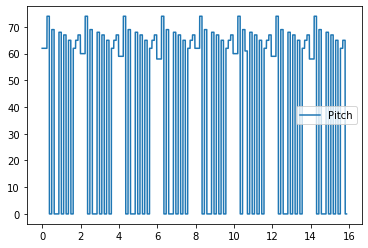

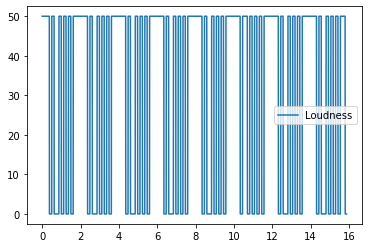

In [15]:



sampling_rate = 500
noise_amp = 0.01
vibrato_amp = 0.1


mdlk = MidiLikeSeq()
mdlk.load("midi-like.txt")
pitch, loudness, t = mdlk.get_f0_loudness_time(1600)

plt.plot(t, pitch, label='Pitch')
plt.legend()
plt.show()
plt.plot(t, loudness, label='Loudness')
plt.legend()
plt.show()

## Preparing data : 

In [16]:
def sliding_windows(data, seq_length): # label like
    x = []
    y = []

    for i in range(len(data)-seq_length-1):
        _x = data[i:(i+seq_length)]
        _y = data[i+seq_length]
        x.append(_x)
        y.append(_y)

    return np.array(x),np.array(y)


sc = MinMaxScaler()
training_data_pitch = sc.fit_transform(pitch.reshape(-1, 1))
training_data_loudness = sc.fit_transform(loudness.reshape(-1, 1))


seq_length = 4

pitch_x, pitch_y = sliding_windows(training_data_pitch, seq_length)
loudness_x, loudness_y = sliding_windows(training_data_loudness, seq_length)

train_size = int(len(pitch_y) * 0.660)
test_size = len(pitch_y) - train_size

dataX_pitch = Variable(torch.Tensor(np.array(pitch_x)))
dataY_pitch = Variable(torch.Tensor(np.array(pitch_y)))

dataX_loudness = Variable(torch.Tensor(np.array(loudness_x)))
dataY_loudness = Variable(torch.Tensor(np.array(loudness_y)))

trainX_pitch = Variable(torch.Tensor(np.array(pitch_x[:train_size])))
trainY_pitch = Variable(torch.Tensor(np.array(pitch_y[:train_size])))

trainX_loudness = Variable(torch.Tensor(np.array(loudness_x[:train_size])))
trainY_loudness = Variable(torch.Tensor(np.array(loudness_y[:train_size])))

testX_pitch = Variable(torch.Tensor(np.array(pitch_x[train_size:])))
testY_pitch = Variable(torch.Tensor(np.array(pitch_y[train_size:])))

testX_loudness = Variable(torch.Tensor(np.array(loudness_x[train_size:])))
testY_loudness = Variable(torch.Tensor(np.array(loudness_y[train_size:])))

## Model : 

In [17]:
class LSTM(nn.Module):

    def __init__(self, num_classes, input_size, hidden_size, num_layers):
        super(LSTM, self).__init__()
        self.num_classes = num_classes
        self.num_layers = num_layers
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.seq_length = seq_length
        
        self.lstm = nn.LSTM(input_size=input_size, hidden_size=hidden_size,
                            num_layers=num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, num_classes)

    def forward(self, x):
        h_0 = Variable(torch.zeros(
            self.num_layers, x.size(0), self.hidden_size))
        
        c_0 = Variable(torch.zeros(
            self.num_layers, x.size(0), self.hidden_size))
        
        # Propagate input through LSTM
        ula, (h_out, _) = self.lstm(x, (h_0, c_0))
        h_out = h_out.view(-1, self.hidden_size)
        out = self.fc(h_out)

        return out

# Training :

In [18]:
num_epochs = 2000
learning_rate = 0.01

input_size = 1
hidden_size = 2
num_layers = 1

num_classes = 1

lstm = LSTM(num_classes, input_size, hidden_size, num_layers)

criterion = torch.nn.MSELoss()    # mean-squared error for regression
optimizer = torch.optim.Adam(lstm.parameters(), lr=learning_rate)
#optimizer = torch.optim.SGD(lstm.parameters(), lr=learning_rate)

list_losses = []
# Train the model
for epoch in range(num_epochs):
    outputs = lstm(trainX_pitch)
    optimizer.zero_grad()
    
    # obtain the loss function
    loss = criterion(outputs, trainY_pitch)
    
    loss.backward()
    
    optimizer.step()
    list_losses.append(loss.item())
    if epoch % 100 == 0:
      print("Epoch: %d, loss: %1.5f" % (epoch, loss.item()))

Epoch: 0, loss: 0.58812
Epoch: 100, loss: 0.00490
Epoch: 200, loss: 0.00446
Epoch: 300, loss: 0.00418
Epoch: 400, loss: 0.00392
Epoch: 500, loss: 0.00367
Epoch: 600, loss: 0.00343
Epoch: 700, loss: 0.00321
Epoch: 800, loss: 0.00302
Epoch: 900, loss: 0.00288
Epoch: 1000, loss: 0.00278
Epoch: 1100, loss: 0.00272
Epoch: 1200, loss: 0.00267
Epoch: 1300, loss: 0.00265
Epoch: 1400, loss: 0.00263
Epoch: 1500, loss: 0.00262
Epoch: 1600, loss: 0.00262
Epoch: 1700, loss: 0.00261
Epoch: 1800, loss: 0.00261
Epoch: 1900, loss: 0.00261


## Plot Losses : 

No handles with labels found to put in legend.


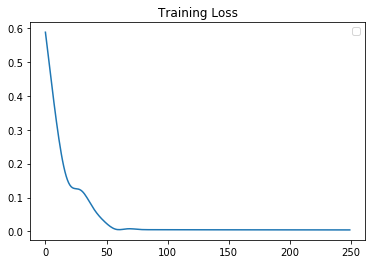

In [19]:
plt.plot(list_losses[:250])
plt.title("Training Loss")
plt.legend()
plt.show()


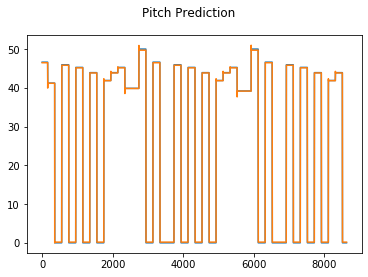

In [22]:
lstm.eval()
train_predict = lstm(testX_pitch)

data_predict = train_predict.data.numpy()
dataY_plot = testY_pitch.data.numpy()

data_predict = sc.inverse_transform(data_predict)
dataY_plot = sc.inverse_transform(dataY_plot)

#plt.axvline(x=train_size, c='r', linestyle='--')

plt.plot(dataY_plot)
plt.plot(data_predict)
plt.suptitle('Pitch Prediction')
plt.show()

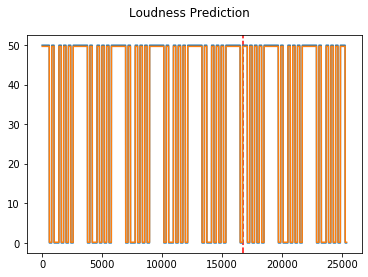

In [23]:
lstm.eval()
train_predict = lstm(dataX_loudness)

data_predict = train_predict.data.numpy()
dataY_plot = dataY_loudness.data.numpy()

data_predict = sc.inverse_transform(data_predict)
dataY_plot = sc.inverse_transform(dataY_plot)

plt.axvline(x=train_size, c='r', linestyle='--')

plt.plot(dataY_plot)
plt.plot(data_predict)
plt.suptitle('Loudness Prediction')
plt.show()